In [8]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [9]:
%cd C:\Users\jdu\Desktop\Projects\menppo

C:\Users\jdu\Desktop\Projects\menppo


In [10]:
actions = [
    'go',
    'back',
    'start',
    'finish'
]

data = np.concatenate([
    np.load('dataset/seq_go_1630842589.npy'),
    np.load('dataset/seq_back_1630842589.npy'),
    np.load('dataset/seq_start_1630842589.npy'),
    np.load('dataset/seq_finish_1630842589.npy')
], axis=0)

data.shape

(1406, 30, 100)

In [11]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1406, 30, 99)
(1406,)


In [12]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1406, 4)

In [13]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1265, 30, 99) (1265, 4)
(141, 30, 99) (141, 4)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                41984     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 44,196
Trainable params: 44,196
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
40/40 [==============================] - ETA: 0s - loss: 277.6037 - acc: 0.3257
Epoch 00001: val_acc improved from -inf to 0.30496, saving model to models\model.h5
40/40 [==============================] - 1s 16ms/step - loss: 277.6037 - acc: 0.3257 - val_loss: 225.4667 - val_acc: 0.3050
Epoch 2/200
36/40 [==========================>...] - ETA: 0s - loss: 428.0883 - acc: 0.3316
Epoch 00002: val_acc improved from 0.30496 to 0.43972, saving model to models\model.h5
40/40 [==============================] - 0s 11ms/step - loss: 563.6557 - acc: 0.3257 - val_loss: 1361.4006 - val_acc: 0.4397
Epoch 3/200
39/40 [============================>.] - ETA: 0s - loss: 379.2325 - acc: 0.5088
Epoch 00003: val_acc improved from 0.43972 to 0.70213, saving model to models\model.h5
40/40 [==============================] - 0s 11ms/step - loss: 375.3108 - acc: 0.5067 - val_loss: 29.5275 - val_acc: 0.7021
Epoch 4/200
37/40 [==========================>...] - ETA: 0s - loss: 5.0610 - acc: 0.8843
Epoc

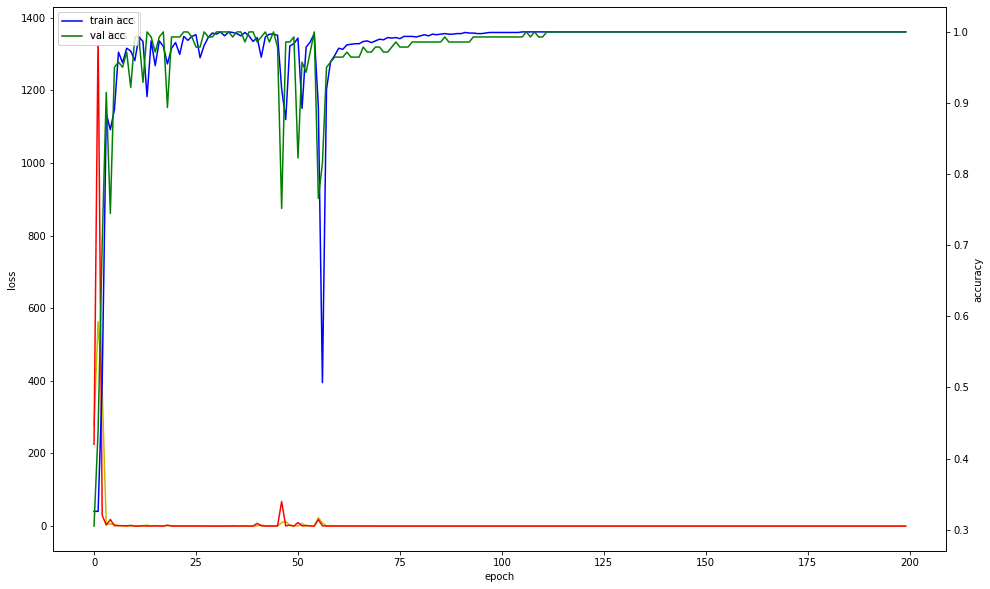

In [16]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [17]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[103,   0],
        [  0,  38]],

       [[100,   0],
        [  0,  41]],

       [[112,   0],
        [  0,  29]],

       [[108,   0],
        [  0,  33]]], dtype=int64)